# Исследование надёжности заёмщиков — анализ банковских данных
На основе данных кредитного отдела банка исследовал влияние семейного положения и количества детей на факт погашения кредита в срок. Была получена информация о данных. Определены и обработаны пропуски. Заменены типы данных на соответствующие хранящимся данным. Удалены дубликаты. Категоризованы данные. Один датафрейм декомпозирован на три.

**Цель исследования:** 
На основе статистики о платёжеспособности клиентов исследовать влияет ли семейное положение и количество детей клиента на факт возврата кредита в срок


Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Подготовка

### Импортируем библиотеки.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from collections import Counter


Смотрим на данные

In [2]:
# чтение файла с данными и сохранение в df
df = pd.read_csv ('/datasets/data.csv')
# получение первых 10 строк таблицы df
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Названия столбцов корректны, оставляем без изменений

Проверяем, нет ли разного написания значений в 'education'

In [4]:
print ('Уникальные значения в столбце в education', 
       df['education'].unique()) # смотрим уникальные значения
# Переводим в нижний регистр
df['education'] = df['education'].str.lower()
print ()
print ('Уникальные значения в столбце в education после перевода в нижний регистр',
       df['education'].unique())

Уникальные значения в столбце в education ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']

Уникальные значения в столбце в education после перевода в нижний регистр ['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']


Теперь все хорошо. Проблема была в том, что одинаковые слова писали в разных регистрах

**Вывод**

  
Итак, в таблице 12 столбцов.

Согласно документации к данным:
* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

Переменные относящиеся к количественным
* Children
* days_employed	
* dob_years
* total_income

Переменные относящиеся к категориальным
* Education
* education_id
* family_status
* family_status_id
* gender
* income_type
* purpose

Переменные относящиеся к логическим
* Debt

## Шаг 2. Предобработка данных

### Обработка пропусков

In [5]:
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Нашли два столбца с пропусками в данных. Это «days_employed» и «total_income» соответственно.
Возможная причина появления пропусков в данных, это технический сбой при копировании. 
Трудовой стаж не связан с целью нашего исследования,
поэтому принимаем решение заменить пропущенные значения на число «-1»,
предварительно проверив что таких значений в данных нет.

In [6]:
print ('Количество значений «-1» в столбце «days_employed»:',
       df[df['days_employed'] == -1]['children'].count())

Количество значений «-1» в столбце «days_employed»: 0



Все хорошо, можем менять пропуски на значение «-1»


In [7]:
df['days_employed'] = df['days_employed'].fillna(-1)


Проверяем, остались ли значения «NaN» в days_employed


In [8]:
df.isnull().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


    
    
В нашем исследовании нужно дать ответы на вопросы:
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

Поэтому смотрим есть ли зависимость в пропущенных данных столбца с уровнем дохода со значениями в столбцах с количеством детей, и семейным положением. Цель кредита будет анализироваться ниже, поэтому в данном случае мы ее проигнорируем чтобы не загромождать код учебного проекта. Гипотеза заключается в следующем: если разница в зависимости будет незначительна (на уровне статистической погрешности), то мы будем считать, что пропуски в таблице были скорее всего случайны, и обусловлены техническими проблемами при формировании таблицы. И мы заполним недостающие данные усредненными значениями по категориям.


In [9]:
print ('Среднее количество детей для записей с пропусками в столбце total_income',
       df[df['total_income'].isna()]['children'].mean())
print ('Среднее количество детей для всех данных',
       df['children'].mean())

Среднее количество детей для записей с пропусками в столбце total_income 0.5524379024839007
Среднее количество детей для всех данных 0.5389082462253194


In [10]:
print ('Таблица с соотношением по семейному статусу для записей с пропусками в столбце total_income')
print ()
print (df[df['total_income'].isna()]['family_status'].value_counts()/df.isnull()['total_income'].sum())
print ()
print ('Таблица с соотношением по семейному статусу для всех данных')
print (df['family_status'].value_counts()/len(df))


Таблица с соотношением по семейному статусу для записей с пропусками в столбце total_income

женат / замужем          0.568997
гражданский брак         0.203312
Не женат / не замужем    0.132475
в разводе                0.051518
вдовец / вдова           0.043698
Name: family_status, dtype: float64

Таблица с соотношением по семейному статусу для всех данных
женат / замужем          0.575145
гражданский брак         0.194053
Не женат / не замужем    0.130685
в разводе                0.055517
вдовец / вдова           0.044599
Name: family_status, dtype: float64



Гипотеза подтвердилась, переходим к заполнению отсутствующих значений.

Анализируем данные в столбце «total_income».
Предполагаем, что ежемесячный доход коррелирует с уровнем образования клиента и типом занятости.

In [11]:
print ('Общее количество')
display(df.pivot_table(index='education', columns='income_type', 
                       values='total_income', aggfunc='count'))
print ('Минимальное значение дохода')
display(df.pivot_table(index='education', columns='income_type', 
                       values='total_income', aggfunc='min'))
print ('Максимальное значение дохода')
display(df.pivot_table(index='education', columns='income_type', 
                       values='total_income', aggfunc='max'))
print ('Медианное значение дохода')
display(df.pivot_table(index='education', columns='income_type', 
                       values='total_income', aggfunc='median'))
print ('Среднее значение дохода')
display(df.pivot_table(index='education', columns='income_type', 
                       values='total_income', aggfunc='mean'))

Общее количество


income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education,,,,,,,,
высшее,1.0,NaN,488.0,1600.0,520.0,1.0,2105.0,1.0
начальное,NaN,NaN,6.0,29.0,93.0,NaN,133.0,NaN
неоконченное высшее,NaN,NaN,46.0,261.0,35.0,NaN,333.0,NaN
среднее,1.0,1.0,771.0,2687.0,2793.0,NaN,7440.0,NaN
ученая степень,NaN,NaN,1.0,NaN,2.0,NaN,3.0,NaN


Минимальное значение дохода


income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education,,,,,,,,
высшее,202722.511368,NaN,44734.262614,42777.827594,35137.992145,499163.144947,32178.213678,98201.625314
начальное,NaN,NaN,53099.539176,71051.529875,25308.586849,NaN,36481.866637,NaN
неоконченное высшее,NaN,NaN,50962.678837,53214.817508,34466.133539,NaN,51022.430000,NaN
среднее,59956.991984,53829.130729,29200.077193,28702.812889,20667.263793,NaN,21367.648356,NaN
ученая степень,NaN,NaN,111392.231107,NaN,98752.495442,NaN,115949.039788,NaN


Максимальное значение дохода


income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education,,,,,,,,
высшее,202722.511368,NaN,910451.470814,2.265604e+06,735103.270167,499163.144947,1.286281e+06,98201.625314
начальное,NaN,NaN,490067.335319,3.786062e+05,296160.300798,NaN,4.078999e+05,NaN
неоконченное высшее,NaN,NaN,514283.242908,9.584346e+05,412386.347106,NaN,8.224260e+05,NaN
среднее,59956.991984,53829.130729,521325.076243,1.597613e+06,681300.590458,NaN,1.726276e+06,NaN
ученая степень,NaN,NaN,111392.231107,NaN,255425.196556,NaN,2.684112e+05,NaN


Медианное значение дохода


income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education,,,,,,,,
высшее,202722.511368,NaN,172511.107016,201785.400018,144240.768611,499163.144947,165640.744634,98201.625314
начальное,NaN,NaN,148339.290825,136798.905143,102598.653164,NaN,125994.910603,NaN
неоконченное высшее,NaN,NaN,160592.345303,179867.152890,120136.896353,NaN,151308.937846,NaN
среднее,59956.991984,53829.130729,136652.970357,159070.690289,114842.854099,NaN,136555.108821,NaN
ученая степень,NaN,NaN,111392.231107,NaN,177088.845999,NaN,198570.757322,NaN


Среднее значение дохода


income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education,,,,,,,,
высшее,202722.511368,NaN,197320.548067,242375.855503,170667.987802,499163.144947,191564.306210,98201.625314
начальное,NaN,NaN,184056.353037,165057.030695,111314.924441,NaN,137212.850187,NaN
неоконченное высшее,NaN,NaN,172476.953367,197649.335647,138312.108423,NaN,174697.072430,NaN
среднее,59956.991984,53829.130729,154055.103706,179490.220250,131698.933496,NaN,152662.997144,NaN
ученая степень,NaN,NaN,111392.231107,NaN,177088.845999,NaN,194310.337215,NaN


Проанализировав данные видим большие различия в минимальных и максимальных значениях относительно средних. Для того чтобы нивелировать влияние крайних значений на данные, принимаем решение использовать медианные значения.

In [12]:
# Создаем временную выборку с медианными значениями
df_temp = df.pivot_table(index='education', columns='income_type', values='total_income', aggfunc='median')
# Создаем функцию, возвращающую медианное значение для выбранной категории
def median_value (df_temp, education, income_type):
    return df_temp.loc[education, income_type]

# Сброс счетчика ошибок
count_errors = 0

for i in range(len(df)):
    if np.isnan(df.loc[i,'total_income']): #Выбираем ячейки со значением «NaN»
        try:
            # Пишем в выбранную ячейку медианное значение из временной выборки
            df.loc[i,'total_income'] = median_value (df_temp, df.loc[i,'education'], df.loc[i,'income_type'])
        except:
            count_errors +=1
    
print ('Количество ошибок:',count_errors) 
#Проверяем, остались ли значения «NaN»
df.isnull().sum()

Количество ошибок: 0


children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**



При обработке пропусков нашли два столбца с пропусками в данных. Это «days_employed» и «total_income». Трудовой стаж не связан с целью нашего исследования, поэтому принимаем решение заменить пропущенные значения на число «-1», предварительно проверив что таких значений в данных нет. Проанализировав данные в столбце «total_income» пришли к выводу что пропуски несут случайный характер, после чего заменили пропуски на медианные значения предварительно сгруппировав данные по уровню образования клиента и типом занятости.

### Замена типа данных

In [13]:
df['days_employed'] = df['days_employed'].astype(int) 
df['total_income'] = df['total_income'].astype(int) 
print ('Проверяем результат')
df.info()

Проверяем результат
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Меняем тип данных на int.

### Обработка дубликатов

Смотрим что в данных:

In [14]:
print (df['education'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


Здесь все хорошо

In [15]:
print (df['family_status'].value_counts())

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64


Здесь все хорошо

In [16]:
print (df['gender'].value_counts())

F      14236
M       7288
XNA        1
Name: gender, dtype: int64


Нашли аномальное значение «XNA» в столбце 'gender'.
На данное исследование значение 'gender' не влияет, поэтому принимаем решение оставить данные без изменений.

In [17]:
print (df['income_type'].value_counts())

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64


Здесь все хорошо

In [18]:
print (df['purpose'].value_counts())

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Здесь все хорошо

In [19]:
print (df['children'].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


Отрицательным количество детей быть не может, предполагаем, что значение «-1» это отсутствие детей.
Причина: различный метод внесения информации о том, что детей нет.
Вносим соответствующие корректировки в базу, "-1" меняем на "0".


In [20]:
df['children'] = ((abs(df['children'])+(df['children']))/2).astype(int) 

Проверяем что получилось убрать отрицательные значения, и прибавить их к нулевым.

In [21]:
print (df['children'].value_counts())

0     14196
1      4818
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64


Все получилось!!!

In [22]:
print (df['debt'].value_counts())

0    19784
1     1741
Name: debt, dtype: int64


Здесь все хорошо

Ищем явные дубликаты

In [23]:
print ('Найдено дубликатов:', df.duplicated().sum())


Найдено дубликатов: 71


Причина: предположительно ошибки при формировании выгрузки.
Удаляем дубликаты, обновляем индексы


In [24]:
df = df.drop_duplicates().reset_index(drop=True)


Проверяем результат


In [25]:
print ('Найдено дубликатов после их удаления:', df.duplicated().sum())

Найдено дубликатов после их удаления: 0


**Вывод**

При обработке данных нашли записи с количеством детей «-1». Заменили их на «0».
Были найдены дубликаты. Их удалили.

### Лемматизация

Для лемматизации целей кредита я разбиваю каждую цель кредита на леммы, объединяю их в один список и смотрю частоту вхождения.


In [26]:
m = Mystem()
temp_lem = []
for i in range(len(df)):
    temp_lem += (m.lemmatize(df.loc[i,'purpose']))
print(Counter(temp_lem)) 

Counter({' ': 33570, '\n': 21454, 'недвижимость': 6351, 'покупка': 5897, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2324, 'свой': 2230, 'на': 2222, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'проведение': 768, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'подержанный': 486, 'подержать': 478, 'приобретение': 461, 'профильный': 436})


Цели кредита хорошо группируются на 4:
- 'недвижимость', 'жилье', 'строительство', 'жилой', 'операция', 'ремонт'
- 'автомобиль'
- 'образование', 'профильный'
- 'свадьба', 'сыграть'

Решил проверить к чему относиться 'операция', к медицине, или недвижимости:

In [27]:
for i in range(len(df)):
    if 'операция' in (m.lemmatize(df.loc[i,'purpose'])): print(df.loc[i,'purpose']) 

операции с жильем
операции с коммерческой недвижимостью
операции с коммерческой недвижимостью
операции со своей недвижимостью
операции с недвижимостью
операции с жильем
операции с коммерческой недвижимостью
операции с коммерческой недвижимостью
операции с коммерческой недвижимостью
операции с недвижимостью
операции со своей недвижимостью
операции с жильем
операции с недвижимостью
операции со своей недвижимостью
операции с коммерческой недвижимостью
операции с коммерческой недвижимостью
операции со своей недвижимостью
операции со своей недвижимостью
операции с недвижимостью
операции с жильем
операции с коммерческой недвижимостью
операции с жильем
операции с коммерческой недвижимостью
операции с коммерческой недвижимостью
операции с недвижимостью
операции с коммерческой недвижимостью
операции с коммерческой недвижимостью
операции с недвижимостью
операции с жильем
операции с жильем
операции с коммерческой недвижимостью
операции со своей недвижимостью
операции с жильем
операции с коммерчес

Оставляем 'операция' в группе с недвижимостью.

**Вывод**

Провели лемматизацию целей кредита.  
Цели кредита хорошо группируются на 4:
* 'недвижимость', 'жилье', 'строительство', 'жилой', 'операция', 'ремонт'
* 'автомобиль'
* 'образование', 'профильный'
* 'свадьба', 'сыграть'


### Категоризация данных

In [28]:
# Функция возвращает к какой категории относится цель получения кредита
# 1 'недвижимость', 2 'автомобиль', 3 'образование’, 4 'свадьба' «-1» 'не найден'.

def purpose_lem (purpose):
    temp_lem = m.lemmatize(purpose) # Пишем во временную переменную, чтобы не вычислять каждый раз значение
    if 'недвижимость' in temp_lem: return 1
    elif 'жилье' in temp_lem: return 1
    elif 'строительство' in temp_lem: return 1
    elif 'жилой' in temp_lem: return 1
    elif 'операция' in temp_lem: return 1
    elif 'ремонт' in temp_lem: return 1
    elif 'автомобиль' in temp_lem: return 2
    elif 'образование' in temp_lem: return 3
    elif 'профильный' in temp_lem: return 3
    elif 'свадьба' in temp_lem: return 4
    elif 'сыграть' in temp_lem: return 4
    else: return -1

# Добавляем колонку 'purpose_id' с категорией получения кредита.    

df['purpose_id'] = df['purpose'].apply(purpose_lem)

# Проверяем что получилось
df.info()
print ()
# Проверяем, нет ли значений «-1»
print (df['purpose_id'].value_counts())
# Все значения найдены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
children            21454 non-null int64
days_employed       21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null int64
purpose             21454 non-null object
purpose_id          21454 non-null int64
dtypes: int64(8), object(5)
memory usage: 2.1+ MB

1    10811
2     4306
3     4013
4     2324
Name: purpose_id, dtype: int64


 Категоризация дохода

In [29]:
purpose_list = [[1, 'недвижимость'], [2, 'автомобиль'], [3, 'образование'], [4, 'свадьба']] # создаем список с ключами
df_purpose_list =  pd.DataFrame(purpose_list, columns=['purpose_id', 'Цель кредита']) # преобразуем список в датафрейм
df_purpose_list     # проверяем что получилось       

,purpose_id,Цель кредита
0,1,недвижимость
1,2,автомобиль
2,3,образование
3,4,свадьба


Словари:
- purpose	purpose_id
- family_status	family_status_id
- education	education_id
- df_purpose_list

## Шаг 3. Проверка гипотез

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [30]:
df_children = df.pivot_table(index='debt', columns='children', values='total_income', aggfunc='count') # сделали сводную таблицу по должникам и детям
df_children = df_children.fillna(0) # обнулили NaN
df_children = df_children.astype(int) # меняем тип значений на int
df_children[1] = df_children.sum(axis=1) - df_children[0] # в столбец «1» пишем общее количество с детьми.
df_children = df_children.drop([2,3,4,5,20], 1) # удаляем все столбцы кроме 0 и 1
df_children.set_axis(['Нет детей','Есть дети'],axis = 1,inplace = True) # меняем подписи к столбцам
df_children.set_axis(['Задолженности нет','Задолженность есть'],axis = 0,inplace = True) # меняем подписи к строкам
print ('Данные в абсолютных значениях')
display (df_children)
print ('Расчет доли')
df_children['Нет детей'] = df_children['Нет детей']/(df_children['Нет детей'].sum())  # Переводим абсолютные значения в расчет доли
df_children['Есть дети'] = df_children['Есть дети']/(df_children['Есть дети'].sum())  # Переводим абсолютные значения в расчет доли
display (df_children)
children_0 = (df_children['Нет детей'][0])/(df_children['Нет детей'].sum()) # Вероятность возврата кредита в срок при отсутствии детей
children_1 = (df_children['Есть дети'][0])/(df_children['Есть дети'].sum()) # Вероятность возврата кредита в срок при наличии детей



Данные в абсолютных значениях


,Нет детей,Есть дети
Задолженности нет,13074,6639
Задолженность есть,1064,677


Расчет доли


,Нет детей,Есть дети
Задолженности нет,0.924742,0.907463
Задолженность есть,0.075258,0.092537


**Вывод**

In [31]:
print (f'Вероятность возврата кредита в срок при отсутствии детей составляет {children_0:.2%}')
print (f'Вероятность возврата кредита в срок при наличии детей составляет {children_1:.2%}')
print (f'Вывод: отсутствие детей повышает вероятность возврата кредита в срок на {(children_0 - children_1):.2%}')

Вероятность возврата кредита в срок при отсутствии детей составляет 92.47%
Вероятность возврата кредита в срок при наличии детей составляет 90.75%
Вывод: отсутствие детей повышает вероятность возврата кредита в срок на 1.73%


###  Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [32]:
df_family_status = df.groupby('family_status').agg({'debt': ['count', 'sum']}) # Для каждого семейного статуса нашли общее количество заемщиков, и количество должников.
df_family_status['percentage_of_debtors'] = df_family_status['debt']['sum']/df_family_status['debt']['count'] # Нашли процент должников
df_family_status = df_family_status.sort_values('percentage_of_debtors', ascending=False) # Упорядочили по должникам
df_family_status = df_family_status.drop(['debt'], 1) # Убрали технические столбцы
df_family_status.set_axis(['Вероятность задолженности'],axis = 1,inplace = True) # меняем подписи к столбцам
df_family_status # Выводим результат. Но как поменять название «family_status» и вывести данные в процентах, я так и не смог разобраться.


,Вероятность задолженности
family_status,
Не женат / не замужем,0.097509
гражданский брак,0.093471
женат / замужем,0.075452
в разводе,0.071130
вдовец / вдова,0.065693


**Вывод**

Да, зависимость между семейным положением и возвратом кредита в срок есть. Максимальное различие составляет 2.21%. Развернутые данные в таблице выше.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Чтобы оценить зависимость, нужно разбить уровень доходов на группы, после чего их сравнить.



Проводим графическую оценку данных

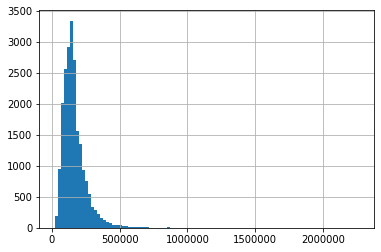

In [33]:
h = df['total_income'].hist(bins = 100)
fig = h.get_figure()

Внешне распределение выглядят ровным.

Проводим стандартную оценку данных

In [34]:
print ('Максимальное значение', df['total_income'].max())
print ('Минимальное значение', df['total_income'].min())
print ('Медианное значение', df['total_income'].median())
print ('Среднее значение', df['total_income'].mean())
print ('Количество значений', df['total_income'].count())


Максимальное значение 2265604
Минимальное значение 20667
Медианное значение 143707.5
Среднее значение 165453.02372517946
Количество значений 21454




Принимаем решение разбить данные на 4 группы: низкие (меньше 10% по количеству); ниже среднего (от 10 % до медианы); выше среднего (от медианы до 90%); высокие (выше 90 %).
    
Получаем значения для разделения диапазонов:

In [35]:
df = df.sort_values('total_income') # сортируем по доходу
df = df.reset_index(drop=True) # сбрасываем индекс
total_income_index_min = df['total_income'].count()//10 # находим индекс записи, стоящей на месте 10% от всех записей с начала
total_income_index_max = total_income_index_min*9 # находим индекс записи, стоящей на месте 90% от всех записей с начала
total_income_min = df.loc[total_income_index_min,'total_income']# получаем значения для разделения диапазонов
total_income_max = df.loc[total_income_index_max,'total_income']# получаем значения для разделения диапазонов
total_income_median = df['total_income'].median()# получаем значения для разделения диапазонов
print ('Уровень дохода разделяющий низкий уровень и уровень ниже среднего', total_income_min)
print ('Уровень дохода разделяющий высокий уровень и уровень выше среднего', total_income_max)


Уровень дохода разделяющий низкий уровень и уровень ниже среднего 78716
Уровень дохода разделяющий высокий уровень и уровень выше среднего 269784


In [36]:
# Функция возвращает к какой категории относится доход
# 1 низкие (меньше 10% по количеству), 2 ниже среднего (от 10 % до медианы), 3 выше среднего (от медианы до 90%), 4 высокие (выше 90 %) «-1» 'не найден'.

def total_income_status (total_income):
    if total_income_min > total_income: return 'низкие'
    elif total_income_median > total_income: return 'ниже среднего'
    elif total_income_max > total_income: return 'выше среднего'
    elif total_income_max <= total_income: return 'высокие'
    else: return -1

# Добавляем колонку 'total_income_status' с категорией получения кредита.    

df['total_income_status'] = df['total_income'].apply(total_income_status)

    
# Проверяем что получилось
df.info()
print ()
# Проверяем, нет ли значений «-1»
print (df['total_income_status'].value_counts())
# Все значения найдены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 14 columns):
children               21454 non-null int64
days_employed          21454 non-null int64
dob_years              21454 non-null int64
education              21454 non-null object
education_id           21454 non-null int64
family_status          21454 non-null object
family_status_id       21454 non-null int64
gender                 21454 non-null object
income_type            21454 non-null object
debt                   21454 non-null int64
total_income           21454 non-null int64
purpose                21454 non-null object
purpose_id             21454 non-null int64
total_income_status    21454 non-null object
dtypes: int64(8), object(6)
memory usage: 2.3+ MB

ниже среднего    8582
выше среднего    8578
высокие          2149
низкие           2145
Name: total_income_status, dtype: int64


In [37]:
df_total_income_status = df.groupby('total_income_status').agg({'debt': ['count', 'sum']}) # Для каждого уровня дохода нашли общее количество заемщиков, и количество должников.
df_total_income_status['percentage_of_debtors'] = df_total_income_status['debt']['sum']/df_total_income_status['debt']['count'] # Нашли процент должников
df_total_income_status = df_total_income_status.sort_values('percentage_of_debtors', ascending=False) # Упорядочили по должникам
df_total_income_status = df_total_income_status.drop(['debt'], 1) # Убрали технические столбцы
df_total_income_status.set_axis(['Вероятность задолженности'],axis = 1,inplace = True) # меняем подписи к столбцам
df_total_income_status # Выводим результат.

,Вероятность задолженности
total_income_status,
ниже среднего,0.087975
выше среднего,0.079039
низкие,0.073193
высокие,0.070265


**Вывод**

Да, зависимость между уровнем дохода и возвратом кредита в срок есть, но не линейная. Максимальное различие составляет 1.77%. Развернутые данные в таблице выше.

###  Как разные цели кредита влияют на его возврат в срок?

In [38]:
df_purpose_status = df.groupby('purpose_id').agg({'debt': ['count', 'sum']}) # Для каждой цели кредита нашли общее количество заемщиков, и количество должников.
df_purpose_status['percentage_of_debtors'] = df_purpose_status['debt']['sum']/df_purpose_status['debt']['count'] # Нашли процент должников
df_purpose_status = df_purpose_status.sort_values('percentage_of_debtors', ascending=False) # Упорядочили по должникам
df_purpose_status = df_purpose_status.drop(['debt'], 1) # Убрали технические столбцы
df_purpose_status = df_purpose_status.merge(df_purpose_list, on='purpose_id', how='left') # объединили с датафреймом хранящем названия ключей
df_purpose_status = df_purpose_status.drop(['purpose_id'], 1) # Убрали технические столбцы
df_purpose_status.set_axis(['Вероятность задолженности','Цель кредита'],axis = 1,inplace = True) # меняем подписи к столбцам
df_purpose_status # Выводим результат.

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,Вероятность задолженности,Цель кредита
0,0.093590,автомобиль
1,0.092200,образование
2,0.080034,свадьба
3,0.072334,недвижимость


**Вывод**

Да, зависимость между целями кредита и возвратом кредита в срок есть. Максимальное различие составляет 1.77%. Развернутые данные в таблице выше.

## Шаг 4. Общий вывод

Проведя данное исследование, мы пришли к выводу, что все 4 фактора виляют на возврат кредита в срок. Наибольшее значение (2.21%) оказывает семейное положение, наименьшее (1.73%) оказывает факт наличия детей. Зависимость между уровнем дохода и возвратом кредита в срок оказалась не линейна. Рекомендую провести дополнительное исследование уточнив какие категории по доходу должны сравниваться. Возможно стоит разделить группы по территориальному признаку, тогда выборка по уровню дохода будет более релевантна.

В итоге у нас получилось, что худший заёмщик:
- это человек с детьми
- не женатый/замужний
- с доходом ниже среднего
- берущий в кредит автомобиль

Лучший же заемщик это:
- это человек без детей
- вдовец / вдова	
- с высоким доходом
- берущий кредит на недвижимость